In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from json import load
import tifffile
from tqdm import tqdm
from skimage.draw import polygon
from matplotlib import rcParams
import glasbey

palette = {
    "orange": "#D17847",
    "blue": "#4F658C",
    "red": "#A83533",
    "green-light": "#44704B",
    "green-dark": "#1F5234",
    "beige": "#D4CCBE",
    "dark-beige": "#B5A47B",
    "black": "#0E0E0E",
    "brown": "#614B29"
}

rcParams['font.family'] = 'sans-serif'
rcParams['figure.facecolor'] = "#FFFFFF00"
rcParams['axes.facecolor'] = "#FFFFFF00"
rcParams['legend.facecolor'] = palette["beige"]
rcParams['legend.framealpha'] = 0.5
rcParams['grid.color'] = palette["beige"]
rcParams['grid.alpha'] = 0.5
rcParams['axes.edgecolor'] = palette["black"]

sns.set_context("paper")

rcParams["font.size"] = 18
rcParams["legend.fontsize"] = 18
rcParams["axes.labelsize"] = 12
s_palette = sns.cubehelix_palette(as_cmap=True)

# linear interpolated colormap from green-light to green-dark
green_blend = sns.color_palette('blend:#8CE59C,#44704C', as_cmap=True)
green_blend_iter = [green_blend(i) for i in np.linspace(0, 1, 5)]

red_blend = sns.color_palette('blend:#FF4F4D,#A83533', as_cmap=True)
red_blend_iter = [red_blend(i) for i in np.linspace(0, 1, 5)]

blue_blend = sns.color_palette('blend:#80A4E4,#4F668E', as_cmap=True)
blue_blend_iter = [blue_blend(i) for i in np.linspace(0, 1, 5)]

orange_blend = sns.color_palette('blend:#ED8751,#B5A47B', as_cmap=True)
orange_blend_iter = [orange_blend(i) for i in np.linspace(0, 1, 5)]

orange_red_blend = sns.color_palette(f'blend:{palette["orange"]},{palette["red"]}', as_cmap=True)
orange_red_blend_iter = [orange_red_blend(i) for i in np.linspace(0, 1, 5)]

orange_brown_blend = sns.color_palette(f'blend:{palette["orange"]},{palette["brown"]}', as_cmap=True)
orange_brown_blend_iter = [orange_brown_blend(i) for i in np.linspace(0, 1, 5)]


In [3]:
from src.utils.tracklets import import_tracklets

roots = ["embryo007", "embryo008", "embryo014a", "embryo016", "embryo018"]
datapath = Path().cwd().parent.parent / "data" / "interim" / "confocal"
plotpath = Path().cwd().parent.parent / "figures"

spots, tracklets, metadata, tracklets_joined = import_tracklets(datapath, roots)
print(spots[roots[0]].columns)

Index(['Unnamed: 0', 'ID', 'track_id', 'tracklet_id', 'distance_from_edge',
       'parent_id', 'daughter_id', 'roi', 'FRAME', 'POSITION_X', 'POSITION_Y',
       'POSITION_Z', 'ELLIPSE_MAJOR', 'ELLIPSE_MINOR', 'ELLIPSE_THETA',
       'ELLIPSE_Y0', 'ELLIPSE_X0', 'ELLIPSE_ASPECTRATIO', 'CIRCULARITY',
       'AREA', 'SHAPE_INDEX', 'MEDIAN_INTENSITY_CH1', 'time', 'um_from_edge',
       'um_x', 'um_y', 'ap_position', 'edge_position', 'track_n_tracklets',
       'cycle'],
      dtype='object')


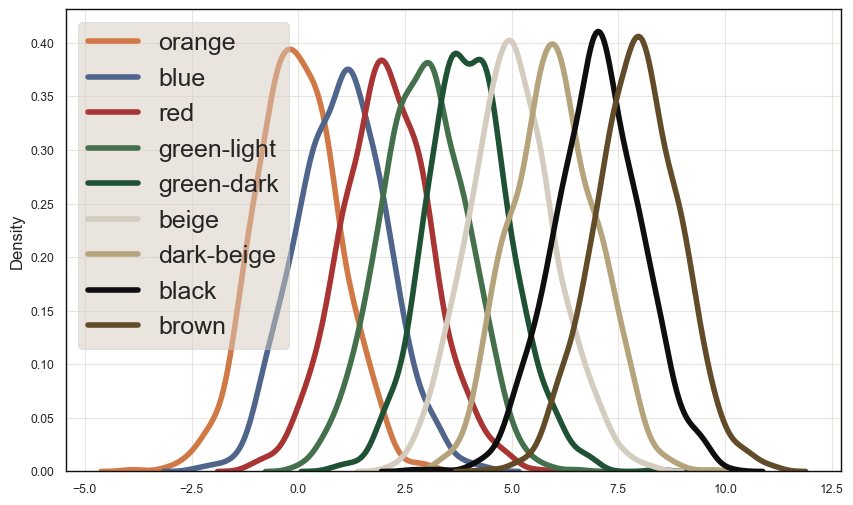

In [4]:
# test seaborn figure
fig, ax = plt.subplots(figsize=(10, 6))
for i, (name, color) in enumerate(palette.items()):
    sns.kdeplot(data=np.random.normal(size=1000) + i, ax=ax, color=color, label=name, linewidth=4)
    
plt.legend()
plt.savefig(plotpath / "seaborn_test.png", dpi=300)


# Timing

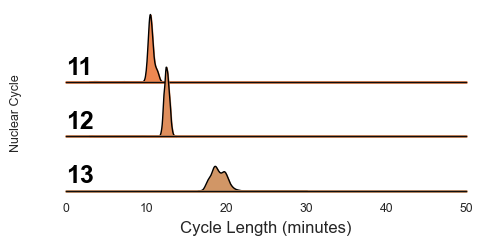

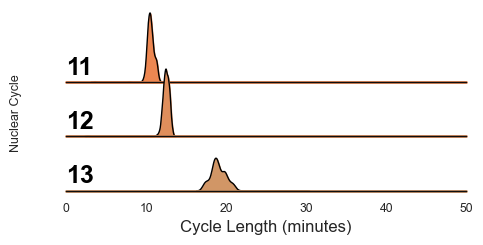

7


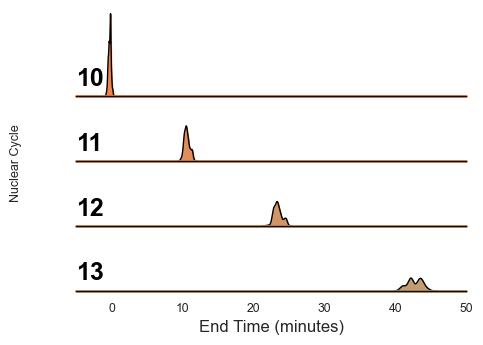

In [5]:
rcParams.update({"axes.grid" : False, "grid.color": "black"})

tracklet = tracklets_joined[tracklets_joined["cycle"].isin([11, 12, 13])]
tracklet = tracklet[tracklet["track_n_tracklets"] == 31]

tracklet = tracklet[tracklet["length"] < 30]

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(tracklet, row="cycle", hue="cycle", aspect=5, height=1, palette=orange_blend_iter)

# Draw the densities in a few steps
g.map(sns.kdeplot, "length",
      clip_on=False,
      fill=True, alpha=1, linewidth=.75)
g.map(sns.kdeplot, "length", clip_on=False, color="k", lw=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.set_xlim([0, 50])
    ax.text(0, .2, label, fontweight="bold", color="k",
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "length")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine( left=True)


g.figure.supylabel("Nuclear Cycle", fontsize=9)
g.axes[-1, 0].set_xlabel("Cycle Length (minutes)")

plt.savefig(plotpath / "nc_length_kde.png", dpi=300)
plt.show()

"""
Calculating time since previous median nuclear cycle
"""

tracklet = tracklets_joined[tracklets_joined["cycle"].isin([11, 12, 13])]
tracklet = tracklet[tracklet["track_n_tracklets"] == 31]
tracklet = tracklet[tracklet["length"] < 30]

tracklet["adjusted_length"] = 0.0
for cycle in [11, 12, 13]:
    median_nc = tracklet[tracklet["cycle"] == cycle].groupby("embryo")["start_time"].median()
    indexer = tracklet["cycle"] == cycle
    tracklet.loc[indexer, "adjusted_length"] = tracklet.loc[indexer, "end_time"] - tracklet.loc[indexer, "embryo"].map(median_nc)

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(tracklet, row="cycle", hue="cycle", aspect=5, height=1, palette=orange_blend_iter)

# Draw the densities in a few steps
g.map(sns.kdeplot, "adjusted_length",
      clip_on=False,
      fill=True, alpha=1, linewidth=.75)
g.map(sns.kdeplot, "adjusted_length", clip_on=False, color="k", lw=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.set_xlim([0, 50])
    ax.text(0, .2, label, fontweight="bold", color="k",
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "adjusted_length")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine( left=True)


g.figure.supylabel("Nuclear Cycle", fontsize=9)
g.axes[-1, 0].set_xlabel("Cycle Length (minutes)")

plt.savefig(plotpath / "nc_adjusted_length.png", dpi=300)
plt.show()
"""
End-time based approach
"""
tracklet = tracklets_joined[tracklets_joined["cycle"].isin([10, 11, 12, 13])]
tracklet = tracklet[tracklet["track_n_tracklets"] == 31]
tracklet = tracklet[tracklet["length"] < 30]

tracklet["adjusted_length"] = 0.0
for cycle in [11, 12, 13]:
    median_nc = tracklet[tracklet["cycle"] == cycle].groupby("embryo")["start_time"].median()
    indexer = tracklet["cycle"] == cycle
    tracklet.loc[indexer, "adjusted_length"] = tracklet.loc[indexer, "end_time"] - tracklet.loc[indexer, "embryo"].map(median_nc)

# calculate median nc10 time for each embryo as column
median_nc10 = tracklet[tracklet["cycle"] == 11].groupby("embryo")["start_time"].median()
tracklet["median_nc10"] = tracklet["embryo"].map(median_nc10)
tracklet["adjusted_time"] = tracklet["end_time"] - tracklet["median_nc10"]

# remove complete outliers
medians = tracklet.groupby("cycle")["adjusted_time"].median()
stds = tracklet.groupby("cycle")["adjusted_time"].std()
tracklet["median_cycle"] = tracklet["cycle"].map(medians)
tracklet["std_cycle"] = tracklet["cycle"].map(stds)
tracklet["z_score"] = (tracklet["adjusted_time"] - tracklet["median_cycle"]) / tracklet["std_cycle"]
print(sum(tracklet["z_score"].abs() > 3))
tracklet = tracklet[tracklet["z_score"].abs() < 3]

# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(tracklet, row="cycle", hue="cycle", aspect=5, height=1, palette=orange_blend_iter)

# Draw the densities in a few steps
g.map(sns.kdeplot, "adjusted_time",
      clip_on=False,
      fill=True, alpha=1, linewidth=.75)
g.map(sns.kdeplot, "adjusted_time", clip_on=False, color="k", lw=1)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.set_xlim([-5, 50])
    ax.text(0, .2, label, fontweight="bold", color="k",
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "adjusted_time")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine( left=True)


g.figure.supylabel("Nuclear Cycle", fontsize=9)
g.axes[-1, 0].set_xlabel("End Time (minutes)")

plt.savefig(plotpath / "nc_timing_kde.png", dpi=300)
plt.show()
# plt.savefig(plotpath / f"{root}_length_kde.png", dpi=300)

In [6]:
print(tracklet.groupby("cycle")["adjusted_time"].std())
print(tracklet.groupby("cycle")["adjusted_length"].std())
print(tracklet.groupby("cycle")["length"].std())
# calculate f test adjusted_length vs length to compare variances
# from scipy.stats import f_oneway
# for cycle in [11, 12, 13]:
#     print(cycle)
#     print(f_oneway(tracklet[tracklet["cycle"] == cycle]["adjusted_length"], tracklet[tracklet["cycle"] == cycle]["length"]))
#     sns.histplot(data=tracklet[tracklet["cycle"] == cycle], x="adjusted_length", bins=20, color=palette["orange"], stat="density", kde=True)
#     sns.histplot(data=tracklet[tracklet["cycle"] == cycle], x="length", bins=20, color=palette["red"], stat="density", kde=True)
#     plt.show()



embryo_tracklet = tracklet[tracklet["embryo"] == "embryo018"]
print(embryo_tracklet.groupby("cycle")["adjusted_time"].std())
print(embryo_tracklet.groupby("cycle")["length"].std())

cycle
10    0.181418
11    0.394977
12    0.591424
13    1.033526
Name: adjusted_time, dtype: float64
cycle
10    0.000000
11    0.394977
12    0.368615
13    0.950912
Name: adjusted_length, dtype: float64
cycle
10    2.646356
11    0.379126
12    0.309869
13    0.881510
Name: length, dtype: float64
cycle
10    0.160170
11    0.239784
12    0.367659
13    0.833060
Name: adjusted_time, dtype: float64
cycle
10    0.827023
11    0.171810
12    0.253991
13    0.574529
Name: length, dtype: float64


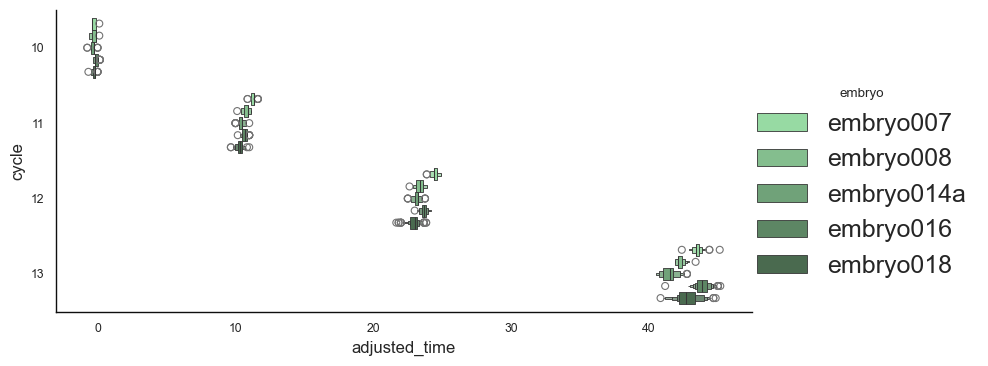

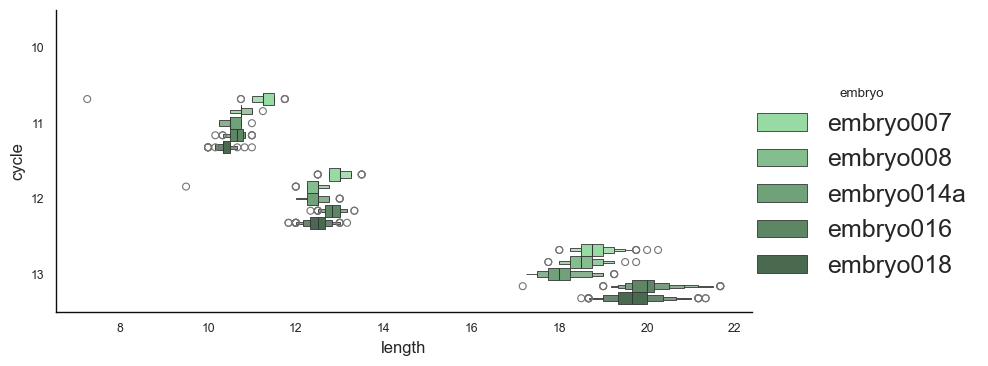

In [7]:
tracklet["cycle"] = pd.Categorical(tracklet["cycle"])
sns.catplot(data=tracklet, y="cycle", x="adjusted_time", hue="embryo", kind="boxen", aspect=2, height=4, palette=green_blend_iter)
plt.show()
sns.catplot(data=tracklet[tracklet["cycle"] != 10], y="cycle", x="length", hue="embryo", kind="boxen", aspect=2, height=4, palette=green_blend_iter)
plt.show()

In [8]:
for cycle in tracklet["cycle"].unique():
    print(cycle)
    print(tracklet[tracklet["cycle"] == cycle].groupby("embryo")["adjusted_time"].std())
    print(tracklet[tracklet["cycle"] == cycle].groupby("embryo")["length"].std())

13
embryo
embryo007     0.305957
embryo008     0.256850
embryo014a    0.548937
embryo016     0.488611
embryo018     0.833060
Name: adjusted_time, dtype: float64
embryo
embryo007     0.344165
embryo008     0.319084
embryo014a    0.457993
embryo016     0.492615
embryo018     0.574529
Name: length, dtype: float64
10
embryo
embryo007     0.140527
embryo008     0.205569
embryo014a    0.170034
embryo016     0.148711
embryo018     0.160170
Name: adjusted_time, dtype: float64
embryo
embryo007     0.140527
embryo008     0.222439
embryo014a    0.170034
embryo016     0.148711
embryo018     0.827023
Name: length, dtype: float64
11
embryo
embryo007     0.158604
embryo008     0.253704
embryo014a    0.205515
embryo016     0.176212
embryo018     0.239784
Name: adjusted_time, dtype: float64
embryo
embryo007     0.532157
embryo008     0.151268
embryo014a    0.164505
embryo016     0.174436
embryo018     0.171810
Name: length, dtype: float64
12
embryo
embryo007     0.214340
embryo008     0.283631
embryo01

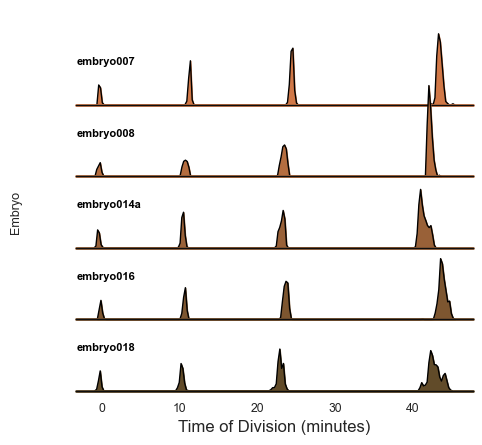

In [9]:
from matplotlib.colors import ListedColormap
# Initialize the FacetGrid object
pal = sns.cubehelix_palette(5, rot=-.25, light=.7)
g = sns.FacetGrid(tracklet, row="embryo", hue="embryo", aspect=5, height=1, palette=orange_brown_blend_iter)

# Draw the densities in a few steps
g.map(sns.kdeplot, "adjusted_time",
      clip_on=False,
      fill=True, alpha=1, linewidth=.75, bw_adjust=0.02)
g.map(sns.kdeplot, "adjusted_time", clip_on=False, color="k", lw=1, bw_adjust=0.02)

# passing color=None to refline() uses the hue mapping
g.refline(y=0, linewidth=2, linestyle="-", color=None, clip_on=False)


# Define and use a simple function to label the plot in axes coordinates
def label(x, color, label):
    ax = plt.gca()
    ax.text(0, .45, label, fontweight="bold", color="k", size=8,
            ha="left", va="center", transform=ax.transAxes)


g.map(label, "adjusted_time")

# Set the subplots to overlap
g.figure.subplots_adjust(hspace=-.25)

# Remove axes details that don't play well with overlap
g.set_titles("")
g.set(yticks=[], ylabel="")
g.despine( left=True)


g.figure.supylabel("Embryo", fontsize=9)
g.axes[-1, 0].set_xlabel("Time of Division (minutes)")

plt.savefig(plotpath / "embryo_nc_timing_kde.png", dpi=300)
plt.show()

# Geometry

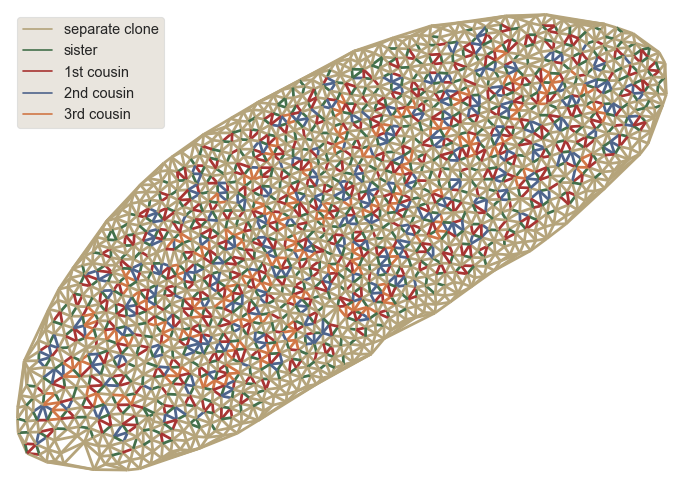

In [10]:
from scipy.spatial import Voronoi
from matplotlib.collections import LineCollection

labels = {0: "separate clone", 1: "sister", 2: "1st cousin", 3: "2nd cousin", 4: "3rd cousin"}
colors = {0: palette["dark-beige"], 1: palette["green-light"], 2: palette["red"], 3: palette["blue"], 4: palette["orange"]}

rcParams['axes.edgecolor'] = "#00000000"

root_c = []
cycle_c = []
tracklet_a_c = []
tracklet_b_c = []
track_a_c = []
track_b_c = []
rca_c = []
gen_diff_c = []

def cousin_distance(tracklet_parents, a, b):
    a_lin, b_lin = [a], [b]
    while a_lin[-1] != -1:
        a_lin.append(tracklet_parents[a_lin[-1]])
    while b_lin[-1] != -1:
        b_lin.append(tracklet_parents[b_lin[-1]])
    for i, a in enumerate(a_lin):
        for j, b in enumerate(b_lin):
            if a == b:
                if a == -1:
                    return 0, 0
                return min(i, j), abs(i - j)

root = "embryo018"
root_frames = range(int(spots[root]["FRAME"].max()))
xmin, ymin = spots[root][["um_x", "um_y"]].min()
xmax, ymax = spots[root][["um_x", "um_y"]].max()    
frame = root_frames[-1]

df = spots[root]
df = df[df["FRAME"] == frame]
cycle = df["cycle"].median()
pts = df[["um_x", "um_y"]].values
tracklet_ids = df["tracklet_id"].values
track_ids = df["track_id"].values

fig, ax = plt.subplots(figsize=(10, 6))

vor = Voronoi(pts)
    
good_tracklets = tracklets[root][tracklets[root]["track_n_tracklets"] > 15]
tracklet_parents = {tracklet: parent for tracklet, parent in zip(tracklets[root]["tracklet_id"], tracklets[root]["parent_tracklet"])}
lines = []
linecolors = []
points = []
pointcolors = []

seen_pairs = set()

for a, b in vor.ridge_points:
    if a == -1 or b == -1:
        continue
        
    # if not tracklet_ids[a] in good_tracklets["tracklet_id"] or not tracklet_ids[b] in good_tracklets["tracklet_id"]:
    #     continue
    if (a, b) in seen_pairs or (b, a) in seen_pairs:
        continue
    seen_pairs.add((a, b))
    
    max_dis = 45
    if np.linalg.norm(pts[a] - pts[b]) > max_dis:
        continue
        
    track_a = tracklet_ids[a]
    track_b = tracklet_ids[b]
    dist, diff = cousin_distance(tracklet_parents, track_a, track_b)
    
    if dist > 4 or diff > 4:
        continue
            
    lines.append([(pts[a, 0], pts[a, 1]), (pts[b, 0], pts[b, 1])])
    linecolors.append(colors[dist])
    
    
lc = LineCollection(lines, colors=linecolors, linewidths=2, zorder=1)
ax.add_collection(lc)
 
# add legend
for i in range(5):
    plt.plot([], [], color=colors[i], label=labels[i])
plt.legend(loc="upper left", fontsize="xx-small")

# set equal axis
ax.set_aspect("equal")
ax.set_xlim(xmin, xmax)
ax.set_ylim(ymin, ymax)
ax.grid(False)

# remove axes
ax.set_xticks([])
ax.set_yticks([])
plt.savefig(plotpath / "cousins_lines.png", dpi=300, bbox_inches="tight", pad_inches=0)
plt.show()
plt.close()

In [11]:
from scipy.spatial import Voronoi
from math import floor
import networkx as nx

graphs = {}
neighbors_all, graph_distances_all, graph_max_all = [], [], []
um_distances_all = []
counts_all = []
# con_counts_all = []

for root in roots:
    graphs[root] = []
    for frame in tqdm(range(0, int(spots[root]["FRAME"].max()), 5)):
        graph = nx.Graph()
        
        embryo_points = spots[root]
        embryo_points = embryo_points[embryo_points["FRAME"] == frame]

        pts = embryo_points[["um_x", "um_y"]].values
        tracklet_ids = embryo_points["tracklet_id"].values

        vor = Voronoi(pts)

        for a, b in vor.ridge_points:
            graph.add_edge(tracklet_ids[a], tracklet_ids[b])
            
        graphs[root].append(graph)
        
    this_tracklets = tracklets[root]
    
    track_counts = this_tracklets["track_id"].value_counts()
    best_tracks = track_counts[track_counts == 31].index
    
    track_tracklets = {key: [] for key in best_tracks}
    best_tracklets = this_tracklets[this_tracklets["track_id"].isin(best_tracks)]
    for tracklet in best_tracklets.index:
        track_tracklets[best_tracklets.loc[tracklet, "track_id"]].append(tracklet)
        
    this_tracklets["parent_tracklet"].fillna(0, inplace=True)
        
    tracklet_parents = {tracklet: parent for tracklet, parent in zip(this_tracklets["tracklet_id"], this_tracklets["parent_tracklet"])}
    
    neighbors = np.zeros((5, 5))
    graph_distances = np.zeros((5, 5))
    graph_max = np.zeros((5, 5))
    counts = [[[] for _ in range(5)] for _ in range(5)]
    um_dist = [[[] for _ in range(5)] for _ in range(5)]
    
    for track in tqdm(best_tracks):
        for frame in range(len(graphs[root])):
            subgraph = graphs[root][frame].subgraph(track_tracklets[track])
            nodes = list(subgraph.nodes)

            for i, a in enumerate(nodes):
                for j, b in enumerate(nodes):
                    if i >= j:
                        continue
                    dist, diff = cousin_distance(tracklet_parents, a, b)
                    if dist > 4 or diff > 4:
                        print("warn")
                    else:
                        neighbors[dist, diff] += 1
                        g_dis = nx.shortest_path_length(graphs[root][frame], a, b)
                        xa, ya = this_tracklets.loc[a, "final_x"], this_tracklets.loc[a, "final_y"]
                        xb, yb = this_tracklets.loc[b, "final_x"], this_tracklets.loc[b, "final_y"]
                        d_dis = np.linalg.norm([xa - xb, ya - yb])
                        graph_distances[dist, diff] += g_dis
                        graph_max[dist, diff] = max(graph_max[dist, diff], g_dis)
                        counts[dist][diff].append(g_dis)
                        um_dist[dist][diff].append(d_dis)
    neighbors_all.append(neighbors)
    graph_distances_all.append(graph_distances)
    graph_max_all.append(graph_max)
    counts_all.append(counts)
    um_distances_all.append(um_dist)

100%|██████████| 58/58 [00:08<00:00,  7.15it/s]


0.0045760640648968565
0.6099861652622312
1.3233867276887872
2.2335846024336115


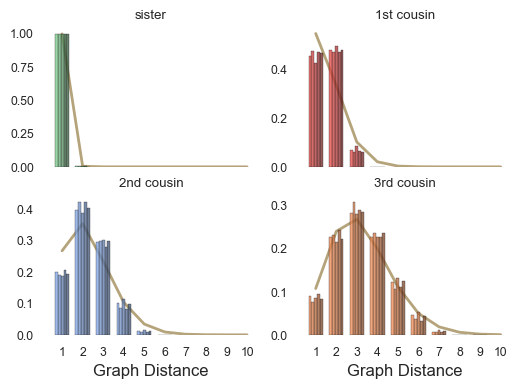

In [27]:
from matplotlib.colors import ListedColormap

pals = [ListedColormap(["#79C788", "#68AA75", "#568E61", "#45724E", "#34563B"]),
        ListedColormap(["#E34744", "#C63E3B", "#AA3533", "#8E2C2B", "#732422"]),
        ListedColormap(["#80A4E4", "#6F8FC6", "#5F7AAA", "#4F668E", "#405272"]),
        ListedColormap(["#ED8751", "#D07747", "#B4673D", "#985734", "#7C472A"])]
fig, axes = plt.subplots(2, 2, figsize=(6, 4), sharex=True)
for j, ax in enumerate(axes.flatten()):
    labels = [i for i, _ in enumerate(roots) for _ in counts_all[i][j + 1][0]]
    vals = [val for i, _ in enumerate(roots) for val in counts_all[i][j + 1][0]]
    df = pd.DataFrame({"vals": vals, "labels": labels})
    
    from scipy.stats import poisson
    x = np.arange(0, 10)
    lam = df["vals"].mean() - 1
    y = poisson.pmf(x, lam)
    ax.plot(x + 1, y, color=palette["dark-beige"], linewidth=2, zorder=-1)
    
    print(lam)
    
    sns.histplot(df, x="vals", hue="labels", discrete=True, ax=ax,  stat="density", multiple="dodge", shrink=0.7, common_norm=False, legend=False, edgecolor=palette["black"], linewidth=0.2, palette=pals[j])
    
    
    ax.set_xlabel("Graph Distance")
    ax.set_xticks(range(1, 11))
    ax.set_ylabel("")
    # ax.set_yticks([])
    # ax.grid(False)
    ax.set_title(f'{["sister", "1st cousin", "2nd cousin", "3rd cousin"][j]}')
# plt.legend(title="Embryo", labels=roots, loc="upper right")
plt.savefig(plotpath / "cousin_distances.png", dpi=150) 
plt.show()

# Progression

In [13]:
ft_spots = {}

for root in roots:
    spot = spots[root]
    ft_spot = spot[spot["track_n_tracklets"] == 31].copy()
    
    rawfile = datapath / root / f"{root}_MaxIP_bgs.tif"
    raw = tifffile.imread(rawfile)
    shape = raw.shape
    
    ft_spot["intensity_mean"] = np.nan
    ft_spot["normed_intensity_mean"] = np.nan
    
    for cycle in [11, 12, 13]:
        ft_cycle = ft_spot[ft_spot["cycle"] == cycle].copy()
        print(f"Root: {root}, Cycle: {cycle}, Number of spots: {ft_cycle.shape[0]}") 
        
        for idx, spot in ft_cycle.iterrows():
            x, y = spot["POSITION_X"], spot["POSITION_Y"]
            t = round(spot["FRAME"])
            new_track_id = spot["track_id"]
            
            roi = [float(pt.lstrip("[ ").rstrip("] ")) for pt in spot["roi"].split(",")]
        
            xs = [round(pt + x) for pt in roi[::2]]
            ys = [round(pt + y) for pt in roi[1::2]]
        
            rr, cc = polygon(ys, xs, shape[1:])
            intensity_vals = raw[tuple([t] + [rr, cc])]
            
            ft_cycle.loc[idx, "intensity_mean"] = intensity_vals.mean()
       
        x = ft_cycle["intensity_mean"]
        ft_cycle["normed_intensity_mean"] = (x - x.mean()) / x.std()
        ft_spot[ft_spot["cycle"] == cycle] = ft_cycle
       
    ft_spots[root] = ft_spot
    
for root in roots:
    ft_spots[root]["normed_area"] = (ft_spots[root]["AREA"] - ft_spots[root]["cycle"].map(ft_spots[root].groupby("cycle")["AREA"].mean())) / ft_spots[root]["cycle"].map(ft_spots[root].groupby("cycle")["AREA"].std())

cycle_subset = {root: ft_spots[root][ft_spots[root]["cycle"].isin([11, 12, 13])].copy() for root in roots}

for root in roots:
    cycle_subset[root]["normed_area_root"] = (cycle_subset[root]["AREA"] - cycle_subset[root]["AREA"].mean()) / cycle_subset[root]["AREA"].std()
    cycle_subset[root]["normed_intensity_root"] = (cycle_subset[root]["intensity_mean"] - cycle_subset[root]["intensity_mean"].mean()) / cycle_subset[root]["intensity_mean"].std()
    

Root: embryo007, Cycle: 11, Number of spots: 3573
Root: embryo007, Cycle: 12, Number of spots: 7332
Root: embryo007, Cycle: 13, Number of spots: 21365
Root: embryo008, Cycle: 11, Number of spots: 3002
Root: embryo008, Cycle: 12, Number of spots: 7047
Root: embryo008, Cycle: 13, Number of spots: 20462
Root: embryo014a, Cycle: 11, Number of spots: 4227
Root: embryo014a, Cycle: 12, Number of spots: 9963
Root: embryo014a, Cycle: 13, Number of spots: 28724
Root: embryo016, Cycle: 11, Number of spots: 6086
Root: embryo016, Cycle: 12, Number of spots: 14651
Root: embryo016, Cycle: 13, Number of spots: 45512
Root: embryo018, Cycle: 11, Number of spots: 7347
Root: embryo018, Cycle: 12, Number of spots: 17621
Root: embryo018, Cycle: 13, Number of spots: 55265


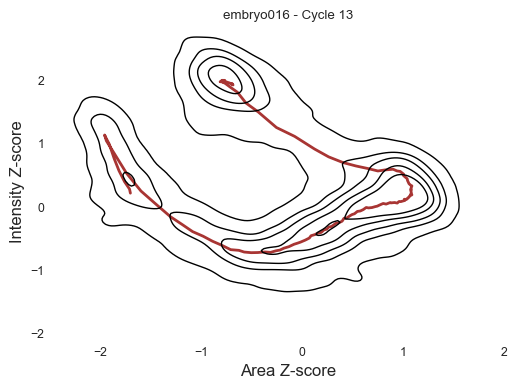

In [14]:
# turn on grid
rcParams['axes.grid'] = False

cycle = 13
root = "embryo016"

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
spot_cycle = cycle_subset[root][cycle_subset[root]["cycle"]==cycle].copy()
        
vals = spot_cycle.groupby("time")[["normed_area_root", "normed_intensity_root"]].median()
count = spot_cycle.groupby("time").size()
template = vals[count > count.max()*0.5]

# sns.scatterplot(spot_cycle.sample(10000), x="normed_area_root", y="normed_intensity_root", hue="time", ax=ax, palette=orange_red_blend, s=1.5, legend=False)
ax.plot(template["normed_area_root"], template["normed_intensity_root"], label="Template", color=palette["red"], linewidth=2)
sns.kdeplot(data=spot_cycle.sample(10000), x="normed_area_root", y="normed_intensity_root", ax=ax, color="black", levels=6, linewidths=1, bw_adjust=0.5)

plt.xlabel("Area Z-score")
plt.ylabel("Intensity Z-score")
plt.title(f"{root} - Cycle {cycle}")

plt.xlim([spot_cycle["normed_area_root"].quantile(0.0001), spot_cycle["normed_area_root"].quantile(0.9999)])
plt.ylim([spot_cycle["normed_intensity_root"].quantile(0.0001), spot_cycle["normed_intensity_root"].quantile(0.9999)])

plt.savefig(plotpath / f"{root}_cycle_{cycle}_scatter.png", dpi=300)
plt.show()


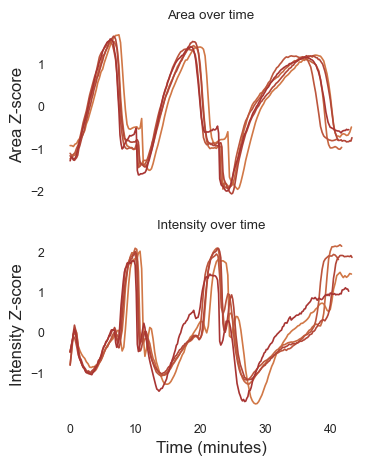

In [15]:
# plot intensity and area over time as separate plots
fig, axes = plt.subplots(2, 1, figsize=(4, 5), sharex=True)

for i, root in enumerate(roots):
    color = orange_red_blend_iter[i]
    cs = cycle_subset[root].copy()
    cs_time_min = cs["time"].quantile(0.001)
    cs_time_max = cs["time"].quantile(0.99)
    cs = cs[(cs["time"] > cs_time_min) & (cs["time"] < cs_time_max)]
    cs["time"] = cs["time"] - cs["time"].min()
    
    grouped = cs.groupby("time")[["normed_area", "normed_intensity_mean"]].median()
    
    sns.lineplot(data=grouped, x="time", color=color, y="normed_area", ax=axes[0], label=root, legend=False)
    axes[0].set_ylabel("Area Z-score")
    axes[0].set_title(f"Area over time")
    
    sns.lineplot(data=grouped, x="time", color=color, y="normed_intensity_mean", ax=axes[1], legend=False)
    axes[1].set_ylabel("Intensity Z-score")
    axes[1].set_title(f"Intensity over time")
    
# plt.subplots_adjust(left=0.5)
plt.xlabel("Time (minutes)")
plt.savefig(plotpath / "area_intensity_time.png", dpi=300)
plt.show()

In [16]:
for root in roots:
    spots[root]["e_id"] = [f"{root}_{idx}" for idx in spots[root].ID]
    spots[root]["e_parent_id"] = [f"{root}_{idx}" for idx in spots[root].parent_id]
    spots[root]["e_track_id"] = [f"{root}_{idx}" for idx in spots[root].track_id]
    spots[root]["e_tracklet_id"] = [f"{root}_{idx}" for idx in spots[root].tracklet_id]
    spots[root]["embryo"] = root
    spots[root]["d_poles"] = 0.5 - np.abs(spots[root].ap_position - 0.5)
    
    for categorical_col in ["e_id", "e_parent_id", "e_track_id", "e_tracklet_id", "embryo", "track_id", "tracklet_id"]:
        spots[root][categorical_col] = pd.Categorical(spots[root][categorical_col])
    
spots_joined = pd.concat(spots.values(), ignore_index=True)
spots_joined.set_index("e_id", inplace=True)

0.018841823118298826


C:\Users\Harrison\AppData\Local\Temp\ipykernel_13344\1048276021.py:18: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([f"{x:.2f}" for x in sorted(np.unique(x_binned))])


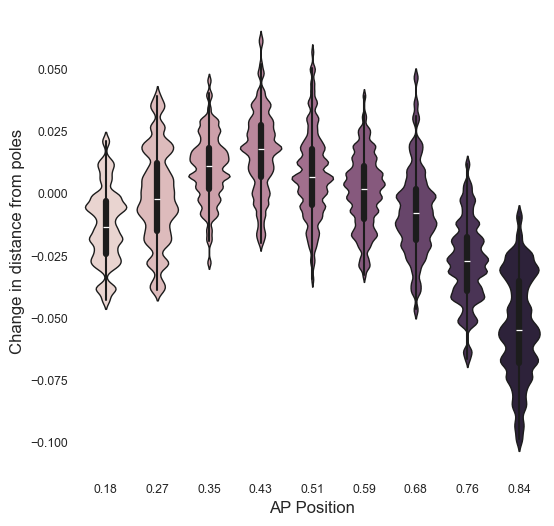

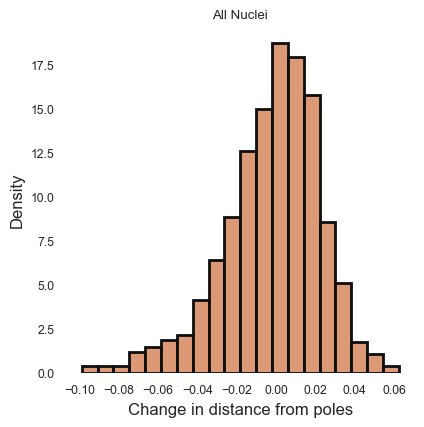

In [28]:

fig, ax = plt.subplots(1, 1, figsize=(6, 6))


spot_df = spots_joined[(spots_joined["track_n_tracklets"] >= 31) & 
                  (spots_joined["track_id"] != 0)].copy()
last_frames = spot_df[spot_df["time"] == spot_df["time"].max()]
first_cycle = spot_df[spot_df["cycle"] == spot_df["cycle"].min()]

x = last_frames.ap_position
x_binned = np.digitize(x, np.linspace(x.min(), x.max()+0.0001, 10)) * (x.max() - x.min()) / 10 + x.min()
# x_binned = [f"{x:.2f}" for x in x_binned]

y = (last_frames.d_poles - last_frames.e_track_id.map(first_cycle.groupby("e_track_id").d_poles.first()))
print(np.mean(abs(y)))

sns.violinplot(x=x_binned, y=y, hue=x_binned, ax=ax, bw_adjust=0.25, legend=False)

ax.set_xticklabels([f"{x:.2f}" for x in sorted(np.unique(x_binned))])
ax.set_xlabel("AP Position")
ax.set_ylabel("Change in distance from poles")

plt.savefig(plotpath / "ap_axis_error.png")  
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

sns.histplot((y), bins=20, stat="density", ax=ax, color=palette["orange"], edgecolor=palette["black"], linewidth=2)
ax.set_xlabel("Change in distance from poles")



# mean, sd = y.median(), y.std()
# ax.axvline(mean, color="red")
# # plot normal
# x = np.linspace(y.min(), y.max(), 100)
# y = 1/(sd * np.sqrt(2 * np.pi)) * np.exp( - (x - mean)**2 / (2 * sd**2) )
# ax.plot(x, y, color="red")

ax.set_title("All Nuclei")


plt.savefig(plotpath / "ap_axis_error_hist.png")
plt.show()

# 3D cleanup

In [18]:
import json

masks = Path(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\cellpose_0625\Recon_fused_tp_165_ch_0_probabilities_masks.tif")
masks = tifffile.imread(masks)[0]
print(masks.shape)

from skimage.measure import regionprops_table
from sklearn.cluster import HDBSCAN

props = regionprops_table(masks, properties=("label", "area", "bbox", "centroid"))

df = pd.DataFrame(props)
X = df[["centroid-0", "centroid-1", "centroid-2"]].values

shapes = {}

with open(r"D:\Tracking\NucleiTracking\data\interim\lightsheet\shapes.json", "r") as f:
    shapes.update({int(k): v for k, v in json.load(f).items()})
    
all_pts = []
for k, v in shapes.items():
    all_pts.extend(v)
    
all_pts = np.array(all_pts)
all_pts[0] = np.mean(all_pts, axis=0)
print(all_pts.shape)

# get min distance of each pt in X to all_pts
from scipy.spatial.distance import cdist

all_pts_dis_to_origin = cdist(all_pts, all_pts)[0]
print(all_pts_dis_to_origin)
dis = cdist(X, all_pts)
nearest = [all_pts_dis_to_origin[k] for k in dis.argmin(axis=1)]
x_dis_to_origin = dis[:, 0]

df["rel_dis"] = nearest - x_dis_to_origin



(371, 983, 415)
(629, 3)
[  0.         423.34382989 420.28768325 413.85810782 371.70406478
 328.2518035  287.15068715 275.75649518 339.48866444 385.79050225
 442.86779318 457.2324893  462.02879313 447.71213795 431.94784011
 409.32068932 347.91235663 322.91131718 260.0561484  228.16514681
 174.83529385 166.43517484 168.17400626 196.19636817 257.58316239
 330.50051824 369.32909675 395.52853792 407.73211147 290.06669507
 346.14336821 383.1948154  408.9414386  416.51806192 416.70210622
 417.04588495 400.48965091 384.07639028 363.3187733  331.94959018
 295.40937988 195.59424093 296.42869048 389.73159977 433.88875274
 450.56982501 461.75016551 432.93071458 388.71354858 325.63731993
 279.34668319 234.90915433 197.03512674 158.53112297 162.37839275
 180.43340603 216.34984175 157.03212125 187.7731344  258.8124266
 317.33954576 364.45991323 380.91751167 397.6524058  403.36225919
 407.43307455 409.3559872  407.69595919 397.29073751 385.71011018
 365.57079902 348.80352188 322.73315274 288.38829416

<Axes: xlabel='centroid-0', ylabel='centroid-1'>

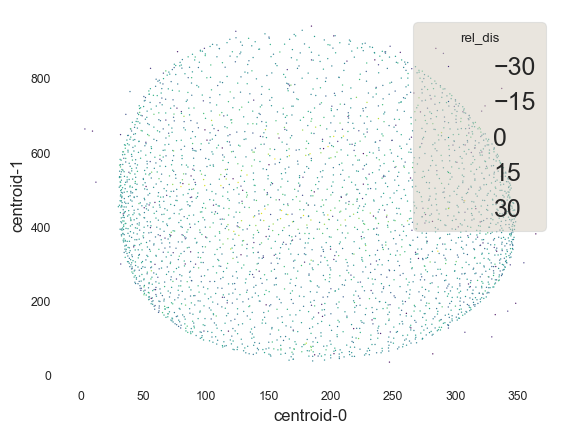

In [19]:
sns.scatterplot(df[df["rel_dis"] > -40], x="centroid-0", y="centroid-1", hue="rel_dis", palette="viridis", s=1)

In [20]:
from skimage.measure import regionprops

cleaned = np.zeros_like(masks)
for i, prop in enumerate(regionprops(masks)):
    if df.iloc[i]["rel_dis"] > -20:
        cleaned[prop.bbox[0]:prop.bbox[3], prop.bbox[1]:prop.bbox[4], prop.bbox[2]:prop.bbox[5]] = prop.image*prop.label

print(cleaned.max())       
tifffile.imwrite(plotpath / "cleaned.tif", cleaned)

3756
